In [1]:
import pandas as pd
import numpy as np

In [2]:
import sympy as sp

In [3]:
import seaborn as sns

/home/m/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from scipy import stats

In [5]:
from numba import jit

# Overview

Given a trading system model $F_{t}(\theta)$, the goal is to adjust the parameters $\theta$ in order to maximise $U_{t}$ (wealth).

$$ \frac{dU_{T}(\theta)}{d\theta} = 
\sum \limits _{t=1} ^ {T} 
\frac{dU_{T}}{dR_{t}} 
\{ \frac{dR_{t}}{dF_{t}} \frac{dF_{t}}{d\theta} + \frac{dR_{t}}{dF_{t-1}} \frac{dF_{t-1}}{d\theta}  \}$$

Where:
* $U$ = wealth function (Sharpe ratio / Sterling ratio)
* $R_{t}$ = realised returns 
* $r_{t}$ = asset returns
* $F_{t}$ = position  
* $\theta$ = model weights
* $\delta$ = transaction costs
* $\mu$ = max position (multiplied by $F_{t}$ which goes from -1 to 1)

#### References

* J. Moody and M. Saffell, "Learning to trade via direct reinforcement," in IEEE Transactions on Neural Networks, vol. 12, no. 4, pp. 875-889, July 2001, doi: 10.1109/72.935097.

* https://teddykoker.com/2019/06/trading-with-reinforcement-learning-in-python-part-ii-application/
* http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf

-----

In [6]:
N = 1/100
NUM_RETURNS = M = 15
FEE = 0.02

## eturns

In [7]:
def get_normalised_returns(n=500):
    df = pd.read_csv('~/Downloads/coinbaseGBP.csv', 
                 names=['_dt', 'price', 'size'])

    df['dt'] = pd.to_datetime(df['_dt'],unit='s')
    df = df.set_index('dt').drop(columns=['_dt'])

    df['ret'] = np.log(df.price) - np.log(df.price.shift(1))

    df = df.tail(n)
    
    rets_z = stats.zscore(df.ret.values)
    rets = np.tanh(rets_z)
    
    return rets

## Calculate positions based on $tanh(\theta \cdot state)$

State takes the form: $[1, R_{t}, R_{t-1}, ..., R_{t-M}, F_{t-1}]$ 

In [8]:
def positions(r, theta):
    '''
    Apply weights to state to determine positisons
    '''
    
    T = len(r)
    Ft = np.zeros(T)
    for t in range(M, T):
        state = np.concatenate([ [1], r[t - M:t], [Ft[t-1]] ])
        Ft[t] = np.tanh(np.dot(theta, state))
        
    return Ft

In [9]:
def returns(Ft, r, delta):
    '''
    Calculate realised returns based on positions and fees
    '''
    T = len(r)
    R = (Ft[0:T-1] * r[1:T]) - delta * (np.abs(Ft[1:T] - Ft[0:T-1]))
    return np.concatenate((np.array([0]), R))

# Derivatives for gradient ascent

# $$ \frac{dU_{T}(\theta)}{d\theta} = 
\sum \limits _{t=1} ^ {T} 
\frac{dU_{T}}{dR_{t}} 
\{ \frac{dR_{t}}{dF_{t}} \frac{dF_{t}}{d\theta} + \frac{dR_{t}}{dF_{t-1}} \frac{dF_{t-1}}{d\theta}  \}$$

----

## $$\frac{dU_{T}}{dR_{t}} $$  
  
  

The *Sterling Ratio* is used as a wealth function:

$$ U_{t} = SterlingRatio = \frac{Annualized Average Return}{Maximum Drawdown}$$  
  
  
  


  
This has been approximated to the Downside Deviation Ratio (DDR):

$$ DDR_{T} = \frac{Average(R_{t})}{DD_{T}} $$

Where $$DD_{T} = (\frac{1}{T}\sum \limits _{t=1} ^ {T} min \{R_{t},0\}^2)^\frac{1}{2} $$

In [10]:
def DDR(R):
    T = len(R)
    R2 = np.zeros(T)
    
    for i in range(0, T):
        R2[i] = min(R[i], 0)**2
        
    return np.mean(R) / (1/T * R2.sum())**0.5

#### Approximated for online learning as:

Exponential moving average of returns:
$$A_{t} = A_{t-1} + n(R_{t} - A_{t-1})$$

In [11]:
def get_A(R):
    T = len(R)
    A = np.zeros(T)
    
    for t in range(NUM_RETURNS, T):
        A[t] = A[t-1] + (N * (R[t] - A[t-1]))
        A[t] = np.nan_to_num(A[t])

    return A

Exponential moving average of squared drawdown: 
$$DD_{t}^2 = DD_{t-1}^2 + n(min(R_{t},0)^2 - DD_{t-1}^2)$$

In [12]:
def get_DD2(R):
    T = len(R)
    DD2 = np.zeros(T)
    for t in range(NUM_RETURNS, T):
        DD2[t] = DD2[t-1] + N * (min(R[t],0)**2 - DD2[t-1])
        DD2[t] = np.nan_to_num(DD2[t])
        
    return DD2

Combined to produce the Differential Downside Deviation Ratio (DDR):

$$D_{t} = \frac{DD_{t-1}^2 \cdot (R_{t} - \frac{1}{2} A_{t-1}) - \frac{1}{2} A_{t-1}R_{t}^2}{DD_{t-1}^3} $$

#### Differential downside deviation ratio 

In [13]:
import sympy as sp

dd_t_1, rt, A_t_1 = sp.symbols('DD_t_-1, R_t, A_t_-1')
Dt = (dd_t_1**2 * (rt - 0.5*A_t_1) - (0.5*A_t_1*rt**2)) / dd_t_1**3

display('Differential downside deviation ratio (Dt):', Dt)

dDdR = sp.diff(Dt, rt)
display('Partial derivative of Dt with respect to Rt:', dDdR)

'Differential downside deviation ratio (Dt):'

(-0.5*A_t_-1*R_t**2 + DD_t_-1**2*(-0.5*A_t_-1 + R_t))/DD_t_-1**3

'Partial derivative of Dt with respect to Rt:'

(-1.0*A_t_-1*R_t + DD_t_-1**2)/DD_t_-1**3

In [14]:
def get_dUdR(A, t, R, DD2):
    return ((-1*A[t-1]*R[t]) + DD2[t-1]) / DD2[t-1]**2

-------

## $$\frac{dR_{t}}{dF_{t}} = -\mu\delta \cdot sgn(F_{t} - F_{t-1})$$

In [15]:
def get_dRdFt(delta, Ft, t):
    return -delta * np.sign(Ft[t] - Ft[t-1])

-----

## $$\frac{dF_{t}}{d\theta} = (1-tanh(\theta^Tx_{t})^2) \cdot \{ x_{t} + w_{M+2} \frac{dF_{t-1}}{d\theta} \}$$

In [16]:
def get_dFtdTheta(Ft, t, state, theta, prev):
    return (1 - Ft[t] ** 2) * (state + theta[-1] * prev)

------

## $$\frac{dR_{t}}{dF_{t-1}} = \mu \cdot r_{t} + \mu\delta \cdot sgn(F_{t}-F_{t-1})$$

In [17]:
def get_dRdFtp(r, delta, Ft, t):
    return r[t] + delta * np.sign(Ft[t] - Ft[t-1])

-----

In [18]:
def gradient(rets, theta, delta):
    Ft = positions(rets, weights) 
    R = returns(Ft, rets, delta) 
   
    # I don't think i need to calc this for all time here, 
    # just N where n = (1/N)
    A = get_A(R)
    DD2 = get_DD2(R)
    
    return _gradient(rets, theta, R, Ft, A, DD2, delta), DDR(R)
    
def _gradient(rets, theta, R, Ft, A, DD2, delta):
    T = len(rets)
    grad = np.zeros(M + 2)
    dFtdTheta_prev = np.zeros(M + 2)
    
    for t in range(M, T):
        state = np.concatenate( (np.array([1]), rets[t - M:t], np.array([Ft[t-1]]) ))
        
        dRdFt = get_dRdFt(delta, Ft, t)

        dFtdTheta = get_dFtdTheta(Ft, t, state, theta, dFtdTheta_prev)
        dFtdTheta_prev = dFtdTheta
        
        dRdFtp = get_dRdFtp(rets, delta, Ft, t)

        dUdR = get_dUdR(A, t, R, DD2)
        
        grad_delta = dUdR * (dRdFt*dFtdTheta) + (dRdFtp*dFtdTheta_prev)
        grad = grad + np.nan_to_num(grad_delta)
                
    return grad

In [19]:
%%time 

epochs = 250
lr = 0.005
weights = np.random.normal(loc=0, scale=1, size=M+2)-1
best_weights = np.zeros(M+2)

rets = get_normalised_returns(n=5000)

loss_history = []
for i in range(0, epochs):
    g, loss = gradient(rets, weights, FEE)
    weights = weights + (lr * g)
    
    loss_history.append(loss)
    if loss == max(loss_history):
        best_weights = weights

/home/m/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


CPU times: user 1min 23s, sys: 534 ms, total: 1min 23s
Wall time: 1min 23s


<AxesSubplot:>

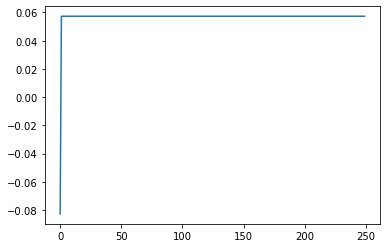

In [20]:
sns.lineplot(range(0, len(loss_history)), loss_history)

In [21]:
Ft = positions(rets, best_weights)

<AxesSubplot:>

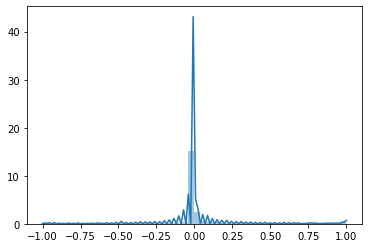

In [22]:
realised_returns = returns(Ft, rets, FEE)
realised_returns = realised_returns[np.where(realised_returns!=0)]
sns.distplot(realised_returns)

<AxesSubplot:>

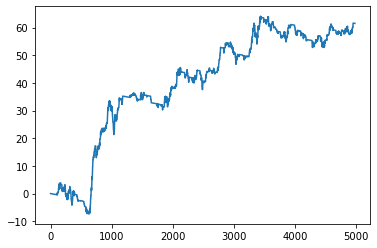

In [23]:
pd.Series(realised_returns).cumsum().plot()